#### Imports

In [6]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path

#### Load Data

In [3]:
assets_path = Path("../data/assets")
factors_path = Path("../data/factors")

returns = pd.read_csv(assets_path / "asset_returns.csv", index_col=0, parse_dates=True)
factors = pd.read_csv(factors_path / "ff3_daily_clean.csv", index_col=0, parse_dates=True)

#### Align Dates

In [4]:
returns = returns.loc[factors.index.intersection(returns.index)]
factors = factors.loc[returns.index]

#### Subtract Risk-Free Rate of Return

In [5]:
excess_returns = returns.sub(factors["RF"], axis=0)

#### Load Model Betas

In [7]:
outputs_path = Path("../outputs")
import pickle

with open(outputs_path / "model_results.pkl", "rb") as f:
    results = pickle.load(f)

#### Create Portfolio of Equal Weights

In [8]:
tickers = returns.columns
n_assets = len(tickers)
weights = np.ones(n_assets) / n_assets

#### Build Beta Matrix

In [30]:
beta_capm.T

,AAPL,AMZN,JNJ,JPM,KO,META,MSFT,PFE,TSLA,XOM
const,0.000569,0.000338,-0.000117,0.000146,0.000023,0.000318,0.000461,-0.000213,0.001632,0.000017
Mkt-RF,1.166061,1.142014,0.473484,1.035446,0.546297,1.276622,1.167358,0.537224,1.586761,0.814368


In [29]:
beta_capm = pd.DataFrame(index=tickers, columns=["const", "Mkt-RF"])

for ticker in tickers:
    model = results[ticker]["CAPM"]
    beta_capm.loc[ticker, ["const", "Mkt-RF"]] = model.params[["const", "Mkt-RF"]]

beta_capm = beta_capm.astype(float)
beta_capm

,const,Mkt-RF
AAPL,0.000569,1.166061
AMZN,0.000338,1.142014
JNJ,-0.000117,0.473484
JPM,0.000146,1.035446
KO,0.000023,0.546297
META,0.000318,1.276622
MSFT,0.000461,1.167358
PFE,-0.000213,0.537224
TSLA,0.001632,1.586761
XOM,0.000017,0.814368


In [31]:
beta_ff3 = pd.DataFrame(index=tickers, columns=["const", "Mkt-RF", "SMB", "HML"])

for ticker in tickers:
    model = results[ticker]["FF3"]
    beta_ff3.loc[ticker, ["const", "Mkt-RF", "SMB", "HML"]] = model.params[["const", "Mkt-RF", "SMB", "HML"]]

beta_ff3 = beta_ff3.astype(float)
beta_ff3.T

,AAPL,AMZN,JNJ,JPM,KO,META,MSFT,PFE,TSLA,XOM
const,0.000491,0.000249,-0.000161,0.000207,-0.000006,0.000235,0.000356,-0.000250,0.001658,0.000103
Mkt-RF,1.179768,1.114778,0.531383,1.112056,0.609986,1.256849,1.192741,0.587875,1.460075,0.874829
SMB,-0.305689,-0.148886,-0.407725,-0.169943,-0.386084,-0.164144,-0.444452,-0.350803,0.670193,-0.016910
HML,-0.380873,-0.731681,0.130028,0.899367,0.265866,-0.641504,-0.465945,0.125330,-0.721295,0.940476


#### Estimate Factor Covariance Matrix

In [16]:
factor_cov = factors[["Mkt-RF", "SMB", "HML"]].cov()
factor_cov

,Mkt-RF,SMB,HML
Mkt-RF,0.000162,0.000020,-0.000010
SMB,0.000020,0.000051,0.000001
HML,-0.000010,0.000001,0.000104


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

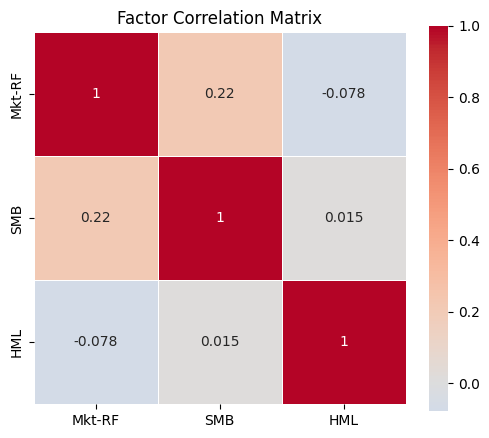

In [34]:
std_dev = np.sqrt(np.diag(factor_cov))
corr_matrix = factor_cov / std_dev[:, None] / std_dev[None, :]

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Factor Correlation Matrix")
plt.show()

#### Residual Variance

In [17]:
residual_var = pd.Series({ticker: results[ticker]["FF3"].mse_resid for ticker in tickers})
residual_var

AAPL    0.000130
AMZN    0.000202
JNJ     0.000106
JPM     0.000090
KO      0.000089
META    0.000389
MSFT    0.000077
PFE     0.000203
TSLA    0.001131
XOM     0.000183
dtype: float64

#### Portfolio Factor Risk

In [18]:
portfolio_beta = np.dot(weights, beta_ff3)
portfolio_var_factor = np.dot(portfolio_beta, np.dot(factor_cov, portfolio_beta.T))
portfolio_var_factor

0.00015608549805609458

#### Portfolio Idiosyncratic Risk

In [20]:
portfolio_var_idiosyncratic = np.dot(weights**2, residual_var)
portfolio_var_idiosyncratic

2.599767504136748e-05

#### Total Portfolio Variance

In [14]:
portfolio_var_total = portfolio_var_factor + portfolio_var_idiosyncratic
portfolio_std_dev = np.sqrt(portfolio_var_total)

print(f"Portfolio Volatility (daily std dev): {portfolio_std_dev:.5f}")

Portfolio Volatility (daily std dev): 0.01349


#### Portfolio VaR

In [15]:
confidence_level = 0.99
VaR = portfolio_std_dev * np.abs(np.percentile(np.random.randn(10000), (1 - confidence_level) * 100))
print(f"Estimated 1-day VaR at {confidence_level*100}% confidence: {VaR:.5f}")

Estimated 1-day VaR at 99.0% confidence: 0.03219
